# Anyone AI

# Project III - Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all together. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.

## Introduction

Kaggle is a web platform and community for data scientist and machine learning engineers where competetitions and datasets are regularly published.

This particular competition is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay its debt or not. The competition finished 4 years ago, so you will find a lot of blog posts and code written for it, we encourage you to read everything you can about it.

The dataset is composed of multiple files with different information about loands taken. In this project we're going to exclusively work with the main files: application_train.csv and application_test.csv.

The competition uses [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

### Getting the data

1- Login to Kaggle (if you don't have an account you'll have to register to get it) and download the [complete dataset](https://www.kaggle.com/competitions/home-credit-default-risk/data). Read the information about the data. What does a row in the main file represent? What does the target variable means?

One row represents one loan in our data sample.
The target variable says wether the loan was repaid (0) or not (1)

2- Load the training and test datasets, we're only going to work withe "application_train.csv" and "application_test.csv" for now

In [ ]:
from google.colab import drive
import IPython.display
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from datetime import datetime,date
import lightgbm as lgb

In [ ]:
### Complete in this cell: Loading the dataset
#mounting drive
drive.mount('/content/drive')
#ignore warnings
warnings.filterwarnings("ignore")
#reading files  
x_train = pd.read_csv('/content/drive/MyDrive/Desarrollo Personal/IA/Anyone AI/3 - AY22 - 03/AY22_03 - Sprint Project/Datasets/application_train.csv')
x_test = pd.read_csv('/content/drive/MyDrive/Desarrollo Personal/IA/Anyone AI/3 - AY22 - 03/AY22_03 - Sprint Project/Datasets/application_test.csv')

Mounted at /content/drive


### Exploratory Data Analysis

A lot of the analysis of the data can be found on public available Kaggle kernels or blog posts, but you need to make sure you understand the datasets properties before starting working on it, so we'll do exploratory data analysis for the main files

**Dataset Basics**

1- Show the shape of the training and test datasets.

In [ ]:
### Complete in this cell: shape of the dataset
print(f'Training shape: {x_train.shape}\nTest shape:{x_test.shape}')

Training shape: (307511, 122)
Test shape:(48744, 121)


2- List all columns in the train dataset

In [ ]:
### Complete in this cell: Show all columns in the training dataset 
IPython.display.HTML(pd.DataFrame(x_train.columns,columns=["DF_COLUMNS"]).to_html())

,DF_COLUMNS
0,SK_ID_CURR
1,TARGET
2,NAME_CONTRACT_TYPE
3,CODE_GENDER
4,FLAG_OWN_CAR
5,FLAG_OWN_REALTY
6,CNT_CHILDREN
7,AMT_INCOME_TOTAL
8,AMT_CREDIT
9,AMT_ANNUITY


3- Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

In [ ]:
### Complete in this cell: show first 5 records in a transposed table
IPython.display.HTML(x_train.iloc[:5].T.to_html())

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
FLAG_OWN_REALTY,Y,N,Y,Y,Y
CNT_CHILDREN,0,0,0,0,0
AMT_INCOME_TOTAL,202500.0,270000.0,67500.0,135000.0,121500.0
AMT_CREDIT,406597.5,1293502.5,135000.0,312682.5,513000.0
AMT_ANNUITY,24700.5,35698.5,6750.0,29686.5,21865.5


4- Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

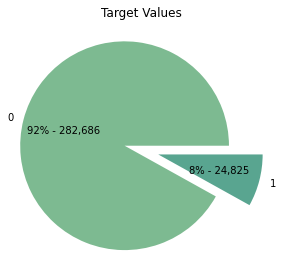

In [ ]:
### Complete in this cell: show distribution of target variable

#defining data
data = x_train["TARGET"].value_counts()
labels = data.index
color = sns.color_palette('crest')

# plotting data on pie chart
plt.pie(
    data,
    labels = labels, 
    colors = color,
    #lambda to calculate percentage with f string
    autopct=lambda x:f'{x:.0f}% - {x*sum(data)/100 :,.0f}',
    explode = [0.2,0.2],
    radius=1.2
    )
#add title and show plot
plt.title('Target Values',pad=25)  
plt.show()

5- Show the number of columns of each data type

In [ ]:
### Complete in this cell: show number of columns per data type
pd.DataFrame(x_train.dtypes.value_counts(),columns = ['COLUMNS_DTYPES'])

,COLUMNS_DTYPES
float64,65
int64,41
object,16


6- For categorical variables, show the number of distinct values in each column (number of labels)

In [ ]:
### Complete in this cell: show number of unique values per categorical column
#build a dataframe and filter by object dtype
cat_cols = pd.DataFrame(x_train.select_dtypes('O').nunique(),columns= ['NUMBER OF LABELS'])

#build a dataframe and filter numerical columns with categorical info (labels <= 5)
num_cat_cols = pd.DataFrame(x_train.select_dtypes('number').nunique(),columns= ['NUMBER OF LABELS'])
num_cat_cols = num_cat_cols[(num_cat_cols['NUMBER OF LABELS']<=5)]

#adding numerical categorical to object type and remove Flags 
cat_cols = cat_cols[~cat_cols.index.str.contains('FLAG')]

cat_cols

,NUMBER OF LABELS
NAME_CONTRACT_TYPE,2
CODE_GENDER,3
NAME_TYPE_SUITE,7
NAME_INCOME_TYPE,8
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
OCCUPATION_TYPE,18
WEEKDAY_APPR_PROCESS_START,7
ORGANIZATION_TYPE,58


7- Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

In [ ]:
### Complete in this cell: checking missing data

#build a dataframe with nan values by headers
missing = pd.DataFrame(x_train.isna().sum(),columns = ['NaN'])

#calculate percentage
missing['% of missing data'] = round(missing['NaN']/ len(x_train.index),3)*100

#sort values descending 
missing = missing.sort_values(by='% of missing data', ascending=False)

#select the first 20 columns
missing.iloc[:20]

,NaN,% of missing data
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4


**Analyzing distribution of variables**

1- Show the distribution of credit amounts

<Figure size 720x360 with 0 Axes>

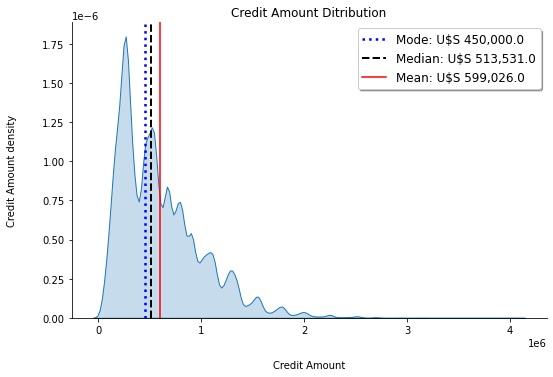

In [ ]:
### Complete in this cell: distribution of credit amounts

# plotting data on distribution chart
plt.figure(figsize=(10,5))
chart = sns.displot(
    data=x_train, 
    x="AMT_CREDIT", 
    kind="kde",
    fill=True,
    height=5, 
    aspect=1.5
    )

#calculate statistics
median = x_train["AMT_CREDIT"].median()
mean = round(x_train["AMT_CREDIT"].mean(),2)
mode = x_train["AMT_CREDIT"].mode()[0]

# add vertical line to show statistical info
plt.axvline(x=mode,color='b',ls=':', lw=2.5,label =f"Mode: U$S {mode:,}")
plt.axvline(x=median,color='black',ls='--', lw=2, label =f"Median: U$S {median:,}")
plt.axvline(x=mean,color='r',ls='-', lw=1.5,label =f"Mean: U$S {mean:,}")

#customize plot
chart.set(title='Credit Amount Ditribution')
plt.xlabel('Credit Amount', fontsize=10,labelpad=25)
plt.ylabel('Credit Amount density', fontsize=10, labelpad=25)
plt.legend(fontsize=12,shadow=True)
plt.show()

2- Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

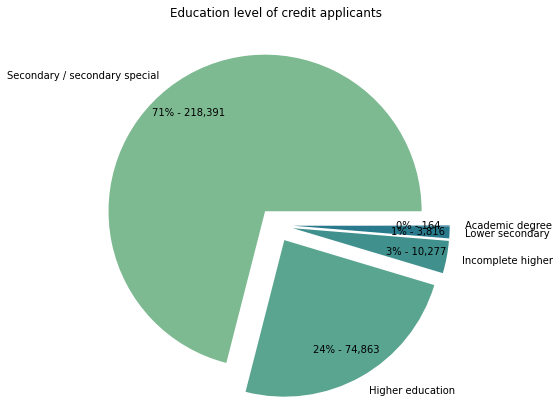

In [ ]:
### Complete in this cell: level of education plot

#defining data
data = x_train["NAME_EDUCATION_TYPE"].value_counts()
labels = x_train["NAME_EDUCATION_TYPE"].unique()
color = sns.color_palette('crest')

# plotting data on pie chart
chart = plt.figure()
chart.set_figheight(4)
plt.pie(
    data,
    labels=labels,
    colors=color,
    autopct=lambda x:f'{x:.0f}% - {x*sum(data)/100 :,.0f}',
    explode = [0.2,0.2,0.2,0.2,0.2],
    pctdistance=0.8,
    labeldistance=1.1,
    radius=1.8,)

# displaying chart
plt.title('Education level of credit applicants',pad=100)  
plt.show()

3- Plot the distribution of ocupation of the loan applicants

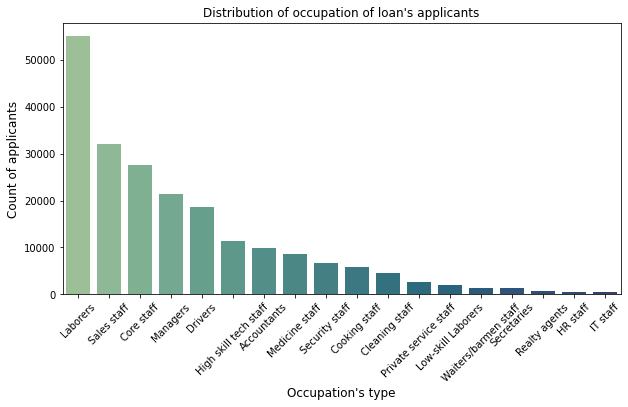

In [ ]:
### Complete in this cell: ocupation of applicants

#plot countplot
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data = x_train,
    x ='OCCUPATION_TYPE',
    order = x_train['OCCUPATION_TYPE'].value_counts().index,
    palette='crest'
    )

#customize plot
chart.set(title="Distribution of occupation of loan's applicants")
chart.set_xlabel("Occupation's type", fontsize = 12)
chart.set_ylabel("Count of applicants", fontsize = 12)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

plt.show()

4- Plot the family status of the applicants

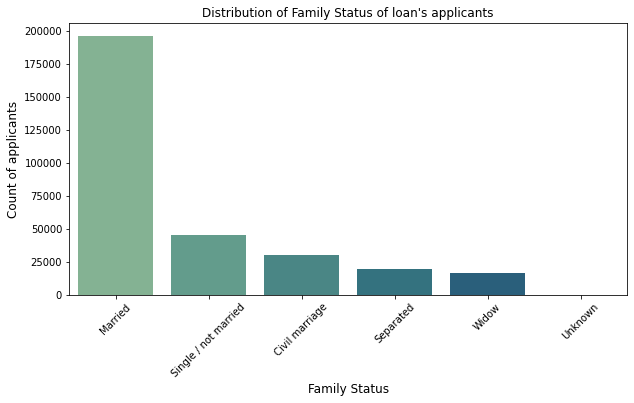

In [ ]:
### Complete in this cell: family status

#plot countplot
plt.figure(figsize=(10,5))
chart = sns.countplot(
   data = x_train, 
   x = "NAME_FAMILY_STATUS", 
   palette="crest",
   order = x_train['NAME_FAMILY_STATUS'].value_counts().index
   )

#customize plot
chart.set(title="Distribution of Family Status of loan's applicants")
chart.set_xlabel("Family Status", fontsize = 12)
chart.set_ylabel("Count of applicants", fontsize = 12)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

5- Plot the income type of applicants grouped by the target variable

<Figure size 720x360 with 0 Axes>

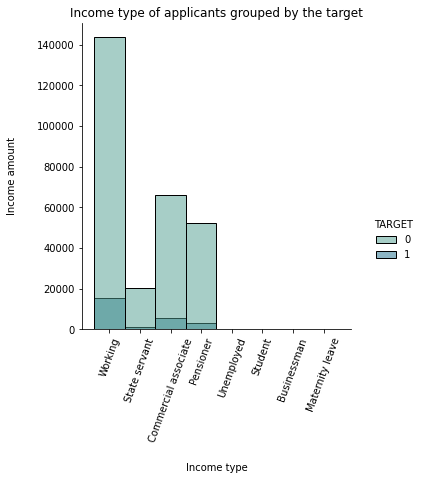

In [ ]:
### Complete in this cell: Income type of applicants by target variable

#plot displot
plt.figure(figsize=(10,5))
chart = sns.displot(
   data = x_train, 
   x = "NAME_INCOME_TYPE",
   hue = 'TARGET', 
   palette = "crest",
   )

#customize plot
chart.set(title="Income type of applicants grouped by the target")
plt.xlabel('Income type', fontsize=10,labelpad=20)
plt.ylabel('Income amount', fontsize=10, labelpad=20)
plt.xticks(rotation=70)

plt.show()

## Preprocessing

In this section, you will code a function to make all the data pre processing for the dataset. What you have to deliver is a function that takes the train and test dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities:

- Correct outliers/anomalous values in numerical columns (hint: take a look at the DAYS_EMPLOYED column)
- Impute values for all columns with missing data (use median as imputing value)
- Encode categorical features:
    - If feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
- Feature scaling

Keep in mind that you could get different number of columns in train and test because some category could only be present in one of the dataframes, this could create more one hot encoded columns. You should align train and test to have the same number of columns

In [ ]:
def na_values_replace(train,test):
  """
  Replace certain NA (XNA,XAP and 365243 ) values with np.NAN.
  It is base on following kaggle discussion:
  https://www.kaggle.com/competitions/home-credit-default-risk/discussion/57248
  
  Parameters:
      Train (Pandas DataFrame): The train split from dataset.
      Test (Pandas DataFrame): The test split from dataset.
    
  Returns:
      Train (Pandas DataFrame): DataFrame with Na values replaced.
      Test (Pandas DataFrame): DataFrame with Na values replaced.
  """
  train = train.replace('XNA', np.NaN)
  train = train.replace('XAP', np.NaN)
  train = train.replace(365243,np.NaN)  
  test = test.replace('XNA', np.NaN)
  test = test.replace('XAP', np.NaN)
  test = test.replace(365243,np.NaN)
  return train,test

In [ ]:
def cut_off_outliers (train):
  """
  This function replace the outliers of following columns by NaN values:

  ['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE']
  
  Outliers are identified by a cut off of 3 standard deviation from the mean.

  Parameters:
      Train (Pandas DataFrame): The train split from dataset.
    
  Returns:
      Train (Pandas DataFrame): The train split from dataset with outliers converted to np.NaN.
  """  
  #list of normal distributed features I consider have outliers
  normal_dist = ['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE']
  for feature in normal_dist:
    #train metrics
    feature_mean = train[feature].mean()
    feature_std = train[feature].std()
    
    #formula to cut off outliers in normal distribution
    cut_off = feature_std
    feature_upper = feature_mean + cut_off
    feature_lower = feature_mean - cut_off
    
    #mask to filter train without outliers by cut off of 3 std from mean
    train[feature][(train[feature] > feature_upper) | (train[feature]  < feature_lower)] = np.NaN

    return train

In [ ]:
def iqr_outliers (train):
  """
  This function replace the outliers of following columns by NaN values:
  
  ['DAYS_EMPLOYED','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE',
  'AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_REGISTRATION','OWN_CAR_AGE',
  'CNT_FAM_MEMBERS','DAYS_LAST_PHONE_CHANGE']

  Outliers are identified by a 1.5 * IQR (interquartile range).

  Parameters:
      Train (Pandas DataFrame): The train split from dataset.
    
  Returns:
      Train (Pandas DataFrame): The train split from dataset with outliers converted to np.NaN.
  """
  #list of skewed distributed features I consider have outliers
  skewed_dist = ['DAYS_EMPLOYED','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_REGISTRATION','OWN_CAR_AGE','CNT_FAM_MEMBERS','DAYS_LAST_PHONE_CHANGE']
  #for loop to correct outliers analytically with IQR in skewed distributions
  for feature in skewed_dist:
    #calculate q's and iqr for train
    q1 = train[feature].quantile(0.25)
    q3 = train[feature].quantile(0.75)
    iqr= q3-q1
    #mask to filter outliers by IQR and assign NaN
    train[feature][(train[feature] <(q1-1.5*iqr)) | (train[feature] >(q3+1.5*iqr))] = np.NaN

    return train

In [ ]:
def impute_nan(train,test):
  """
  This function replace NaN values depending on feature dtype:
  
  Numerical feature (number): replace with feature's median. 
  Categorical feature (object): replace with feature's mode. 

  Parameters:
      Train (Pandas DataFrame): The train split from dataset.
      Test (Pandas DataFrame): The test split from dataset.
    
  Returns:
      Train, Test (Pandas DataFrame): DataFrame with NaN values replaced.
      Test (Pandas DataFrame): DataFrame with NaN values replaced.
  """
  #create a dataframe with sum of NaN values of numerical features
  missing_num_col = pd.DataFrame(train.select_dtypes(include='number').isna().sum(),columns = ['NaN'])
  #filter dataframe by feature's name with Nan values != 0
  missing_num_col =  missing_num_col['NaN'][(missing_num_col['NaN']!=0)].index
  
  #input median values for all numerical columns with missing data
  for feature in missing_num_col:
    train[feature] = train[feature].fillna(train[feature].median())
    test[feature] = test[feature].fillna(test[feature].median())

  #create a dataframe with sum of NaN values of non numerical features
  missing_non_numerical = pd.DataFrame(train.select_dtypes(include='O').isna().sum(),columns = ['NaN'])
  #filter dataframe by feature's name with Nan values != 0
  missing_non_numerical =  missing_non_numerical['NaN'][(missing_non_numerical['NaN']!=0)].index
  
  #input mode values for all non numerical columns with missing data
  for feature in missing_non_numerical:
    train[feature] = train[feature].fillna(train[feature].mode().loc[0])
    test[feature] = test[feature].fillna(test[feature].mode().loc[0])
  return train,test

In [ ]:
def encode(train,test):
  """
  This function encode categorical features using One Hot Encoder.
  If the feature has 2 categories it's enconded with binary OHE.
  Otherwise it's encoded with OHE dropping the first column.
  Then, the encoded feature is removed from dataframe.

  Parameters:
      Train (Pandas DataFrame): The train split from dataset.
      Test (Pandas DataFrame): The test split from dataset.
    
  Returns:
      Train (Pandas DataFrame): DataFrames with categorical features encoded. 
      Test (Pandas DataFrame): DataFrames with categorical features encoded.
  """
  #make a list of binary and multi features
  binary_features= []
  multi_features = []
  for feature in train.select_dtypes('O').columns:
    if train[feature].nunique() <= 2:
      binary_features.append(feature)
    else:
      multi_features.append(feature)  
  
  #declare encoder
  ohe = OneHotEncoder(dtype=int,drop='first', sparse = False, handle_unknown='ignore')

  #encoding multi feature columns on train and test split
  for feature in multi_features:
    ohe_multi_train = ohe.fit_transform(train[[feature]])
    ohe_multi_test = ohe.transform(test[[feature]]) 
    #create columns with categories minus first on train and test
    train[ohe.categories_[0][1:]] = ohe_multi_train
    test[ohe.categories_[0][1:]] = ohe_multi_test
    #drop original column on train and test
    train.drop(columns= feature,inplace= True)
    test.drop(columns= feature,inplace= True)

  ohe = OneHotEncoder(dtype=int,drop='if_binary', sparse = False, handle_unknown='ignore')

  for feature in binary_features:
    ohe_multi_train = ohe.fit_transform(train[[feature]])
    ohe_multi_test = ohe.transform(test[[feature]]) 
    #create columns with categories minus first on train and test
    train[ohe.categories_[0][1:]] = ohe_multi_train
    test[ohe.categories_[0][1:]] = ohe_multi_test
    #drop original column on train and test
    train.drop(columns= feature,inplace= True)
    test.drop(columns= feature,inplace= True)
  
  return train,test

In [ ]:
def scaling(train,test):
  """
  This function scale numerical features using StandardScaler.
  Firstly it set the index of two Dataframes by ['SK_ID_CURR'].
  Then compare the columns between train and test and create the ones on test
  that don't exist in train and assign value 0(zero).
  Finally, before scaling numerical features, those are aligned in both DataFrames
  to mantain column's order.
  
  Parameters:
      Train (Pandas DataFrame): The train split from dataset.
      Test (Pandas DataFrame): The test split from dataset.
    
  Returns:
      Train (Pandas DataFrame): DataFrames with numerical features encoded. 
      Test (Pandas DataFrame): DataFrames with numerical features encoded.
  """
  #set index in both dataframes
  train = train.set_index('SK_ID_CURR')
  test = test.set_index('SK_ID_CURR')

  #compare columns and take the difference
  train_columns = train.columns
  test_columns = test.columns
  diff_columns = list (set(train_columns)-set(test_columns))

  #create new diff feature in test dataset with 0 values
  test[diff_columns] = 0 

  #create a list of features we want to scale
  features = train.select_dtypes(include='number').columns
  
  #align both dataframes features
  train, test = train.align(test, join="outer", axis=1)
  
  #declare scaler
  scaler = StandardScaler()
  
  #scale column by column with each corresponding fit between train and test
  for feature in features:
      train[feature] = scaler.fit_transform(train[[feature]])
      test[feature] = scaler.transform(test[[feature]])
  return train,test

In [ ]:
### Complete in this cell: Data pre processing function   

def pre_processing(train,test):
  """ 
  This function makes all the data pre-processing for the dataset. 
  It takes the train and test dataframes, processes all features, and returns 
  the transformed data as numpy arrays ready to be used for model training.

  Parameters:
      Train (Pandas DataFrame): The train split from dataset.
      Test (Pandas DataFrame): The test split from dataset.
    
  Returns:
      Train (Numpy array)  
      Test (Numpy array) 
      Train Target (Numpy array)
      Test index (Pandas DataFrame)
  """
  # get target feature
  y_train = train['TARGET']
  # drop target feature in train
  train.drop(['TARGET'],axis=1,inplace=True)
  # separate test index
  x_test_index = x_test['SK_ID_CURR']

  train,test = na_values_replace(train,test)
  train = cut_off_outliers(train)
  train = iqr_outliers(train)
  impute_nan (train,test)
  train,test = encode(train,test)
  train,test = scaling(train,test)
  
  return train.to_numpy(),test.to_numpy(),y_train.to_numpy(),x_test_index

In [ ]:
x_train,x_test,y_train,x_test_index = pre_processing(x_train,x_test)

## Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

### Baseline: LogisticRegression

1- Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter 

In [ ]:
def timer(start_time=None):
  """
  This function calculate the time between two points: Start Time and Timer.

  Parameters:
      Start time: given datetime or None (now as default).
    
  Returns:
      Time taken by function in hours (integer), mins(integer) and secs (integer).
  """
  if not start_time:
      start_time=datetime.now()
      return start_time
  elif start_time:
      hour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
      min,sec=divmod(temp_sec,60)
      print(f'Time taken by function: {int(hour)} hours , {int(min)} mins and {int(sec)} secs')

In [ ]:
### Complete in this cell: train a logistic regression 
#instance object logistic regressor
logreg = LogisticRegression(random_state=1,max_iter=1000)

#setting timer to now
start_time = timer(None)

#train and predict 
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)

#use function time based on setting before
timer(start_time)

Time taken by function: 0 hours , 0 mins and 43 secs


2- Use the trained model to predict probabilites for the test data, and then save the results to a csv in the format expected in the competition: a SK_ID_CURR column and a TARGET column with probabilities. REMEMBER: the TARGET columns should ONLY contain the probabilities that the debt is not repaid (equivalent to the class 1).

In [ ]:
def model_prob_csv(model,test,index):
  """
  This function generate a csv with positive probabilities of given model,
  test data and it's index.

  Parameters:
      model (sklearn model)
      test (numpy array)
      index (Pandas DataFrame) with same length as test.
    
  Returns:
      csv with probabilitiest with Index and Target as columns.
  """
  #calculate probabilities
  model_prob = model.predict_proba(test)
  
  # create a dataframe with columns target
  model_prob = pd.DataFrame(model_prob[:,1],columns=['TARGET'])

  #add test index to dataframe
  model_prob['SK_ID_CURR'] = index
  model_prob = model_prob.set_index('SK_ID_CURR')
  
  #save to csv
  return model_prob.to_csv(f"target_{str(model)[:10]}_{date.today().strftime('%d_%m_%Y')}.csv")

In [ ]:
model_prob_csv(logreg,x_test,x_test_index)

3- Go to the Kaggle competition, and in the [submissions page](https://www.kaggle.com/competitions/home-credit-default-risk/submit) load your csv file. Report here the result in the private score you obtained.

At this point, the model should produce a result around 0.67 

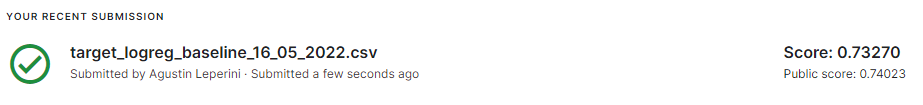

### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

1- Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for n_jobs, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [ ]:
### Complete in this cell: train a RandomForestClassifier

#instance object
rforest = RandomForestClassifier(n_jobs=-1, random_state=1)

#setting timer to now
start_time = timer(None)

#train and predict 
rforest.fit(x_train, y_train)
y_pred = rforest.predict(x_test)

#use function time based on setting before
timer(start_time)

Time taken by function: 0 hours , 2 mins and 36 secs


2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [ ]:
model_prob_csv(rforest,x_test,x_test_index)

3- Load the predictions to the competition. Report the private score here.

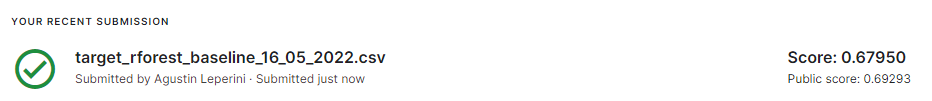

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


1- Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier. The validation metric used to evaluate the models should be "roc_auc".

In [ ]:
### Complete in this cell: Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier

#setting timer to now
start_time = timer(None)

params = {
 'bootstrap': [True, False],
 'max_depth': [200, None,300],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [3,4,5],
 'min_samples_split': [10,12,14],
 'n_estimators': [260,275,290]
}

#instance object
rforest_randomcv = RandomizedSearchCV(
    rforest, params, n_iter=5, random_state=1, cv=5,scoring='roc_auc',verbose=5)

#finding best hyperparameters
rforest_randomcv.fit(x_train, y_train)

#use function time 
timer(start_time)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=275;, score=0.734 total time= 6.6min
[CV 2/5] END bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=275;, score=0.735 total time= 6.6min
[CV 3/5] END bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=275;, score=0.729 total time= 6.5min
[CV 4/5] END bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=275;, score=0.731 total time= 6.6min
[CV 5/5] END bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=275;, score=0.732 total time= 6.6min
[CV 1/5] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=14, n_estimators=275;, score=0.739 total time= 9.5min
[CV 2/5]

In [ ]:
print(f'RandomizedSearchCV on RandomForestClassifier:\n\nBest params:')
for key, values in rforest_randomcv.best_params_.items():
  print(f'{key} : {values}')
print(f"\nBest Score: {rforest_randomcv.best_score_:.6f}\n")

scores = pd.DataFrame(rforest_randomcv.cv_results_)
scores

RandomizedSearchCV on RandomForestClassifier:

Best params:
n_estimators : 275
min_samples_split : 12
min_samples_leaf : 5
max_features : auto
max_depth : 200
bootstrap : False

Best Score: 0.738842



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,392.054523,2.610576,4.469498,0.064380,275,12,3,sqrt,300,True,"{'n_estimators': 275, 'min_samples_split': 12,...",0.734209,0.734647,0.728756,0.730964,0.732224,0.732160,0.002164,4
1,567.496070,4.671603,4.864557,0.049006,275,14,4,auto,None,False,"{'n_estimators': 275, 'min_samples_split': 14,...",0.739350,0.738719,0.734330,0.736655,0.735869,0.736984,0.001844,3
2,543.045800,3.897435,4.527461,0.104742,260,14,5,sqrt,200,False,"{'n_estimators': 260, 'min_samples_split': 14,...",0.739741,0.740936,0.737273,0.737795,0.737861,0.738721,0.001389,2
3,568.381802,6.483172,5.110798,0.118678,275,12,5,auto,200,False,"{'n_estimators': 275, 'min_samples_split': 12,...",0.740965,0.741328,0.735869,0.738683,0.737363,0.738842,0.002085,1
4,375.237900,1.993052,4.394246,0.040396,260,12,3,sqrt,300,True,"{'n_estimators': 260, 'min_samples_split': 12,...",0.733911,0.734418,0.728999,0.730910,0.732116,0.732071,0.001984,5


RandomForestClassifier ROC AUC = 0.999929



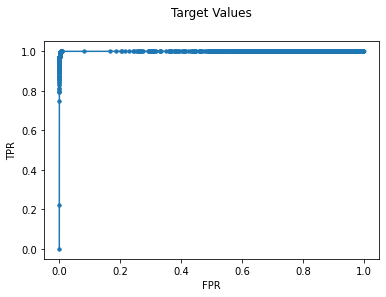

In [ ]:
#predict probabilities on train 
rforest_randomcv_prob = rforest_randomcv.predict_proba(x_train)

#get positive outcome probabilities 
rforest_pos_prob = rforest_randomcv_prob[:, 1]

# Calculate scores
pos_auc = roc_auc_score(y_train, rforest_pos_prob)

# Summarize scores
print(f"RandomForestClassifier ROC AUC = {pos_auc:.6f}\n")

# Calculate roc curves
pos_fpr, pos_tpr, thresholds = roc_curve(y_train, rforest_pos_prob)

#plot ROC AUC
plt.plot(pos_fpr, pos_tpr, marker='.', label='RandomForestClassifier')
plt.title('Target Values',pad=25)  
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [ ]:
model_prob_csv(rforest_randomcv,x_test,x_test_index)

3- Load the predictions to the competition. Report the private score here.

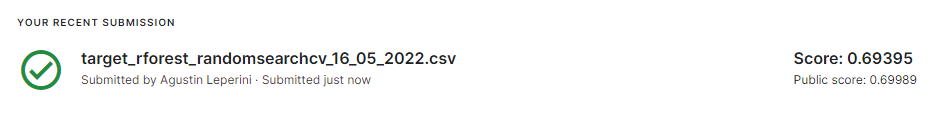

4- If you have the time and resources, you can train the model for longer iterations, or select more estimator sizes. This is optional, but if you, we would love to see your results.

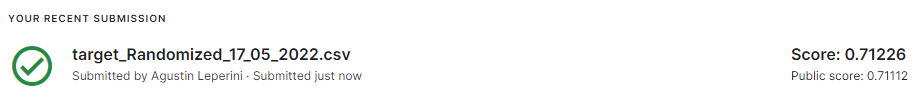

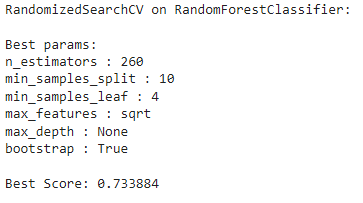

image.png

image.png

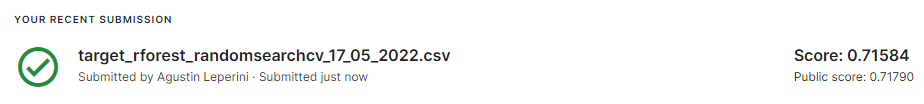
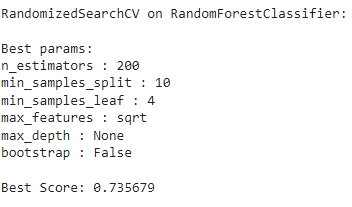

image.png

image.png

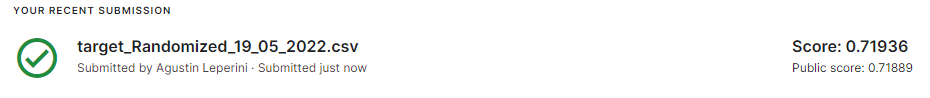

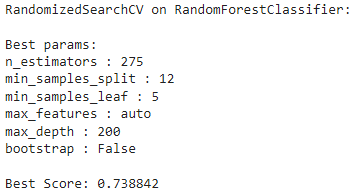

image.png

image.png

### Optional: Training a LightGBM model 

Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [ ]:
#split the train dataset into train and validation (70/30)
train_lgb_x, val_lgb_x, train_lgb_y, val_lgb_y = train_test_split(
    x_train, y_train,test_size=0.30,random_state=1)

print(f"x_train shape = {train_lgb_x.shape}, val_lgb_x shape = {val_lgb_x.shape}")
print(f"train_lgb_y shape = {train_lgb_y.shape}, val_lgb_y shape = {val_lgb_y.shape}")

x_train shape = (215257, 225), val_lgb_x shape = (92254, 225)
train_lgb_y shape = (215257,), val_lgb_y shape = (92254,)


In [ ]:
#convert numpy arrays to train and validation dataset
train = lgb.Dataset(train_lgb_x, label= train_lgb_y)
valid = lgb.Dataset(val_lgb_x, label= val_lgb_y)

#set params
params = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalanced': 'true',
    'boosting':'gbdt',
    'num_leaves': 63,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.01,
    'verbose': -1
    }

#setting timer
start_time = timer(None)

#train the lightgbm model
lgb_bst = lgb.train(params,train,valid_sets=valid,
                    num_boost_round=5000,early_stopping_rounds=50)

#predict the results in train and validation
y_train_pred = lgb_bst.predict(train_lgb_x)
y_val_pred = lgb_bst.predict(x_test)

#use function time based on setting before
timer(start_time)


[1]	valid_0's auc: 0.677471
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's auc: 0.720839
[3]	valid_0's auc: 0.728461
[4]	valid_0's auc: 0.730543
[5]	valid_0's auc: 0.731657
[6]	valid_0's auc: 0.731133
[7]	valid_0's auc: 0.734009
[8]	valid_0's auc: 0.733538
[9]	valid_0's auc: 0.733749
[10]	valid_0's auc: 0.733354
[11]	valid_0's auc: 0.732637
[12]	valid_0's auc: 0.732674
[13]	valid_0's auc: 0.732376
[14]	valid_0's auc: 0.734218
[15]	valid_0's auc: 0.734782
[16]	valid_0's auc: 0.735606
[17]	valid_0's auc: 0.736198
[18]	valid_0's auc: 0.736777
[19]	valid_0's auc: 0.736351
[20]	valid_0's auc: 0.738037
[21]	valid_0's auc: 0.738555
[22]	valid_0's auc: 0.739093
[23]	valid_0's auc: 0.739851
[24]	valid_0's auc: 0.740212
[25]	valid_0's auc: 0.740265
[26]	valid_0's auc: 0.740305
[27]	valid_0's auc: 0.740836
[28]	valid_0's auc: 0.740677
[29]	valid_0's auc: 0.740978
[30]	valid_0's auc: 0.741085
[31]	valid_0's auc: 0.74168
[32]	valid_0's auc: 0.742057
[33]	valid_0's auc: 

In [ ]:
# create a dataframe with columns target on validation predictions
lgb_prob = pd.DataFrame(y_val_pred,columns=['TARGET'])

#add test index to dataframe
lgb_prob['SK_ID_CURR'] = x_test_index
lgb_prob = lgb_prob.set_index('SK_ID_CURR')

#save to csv
lgb_prob.to_csv(f"target_lgb_baseline_{date.today().strftime('%d_%m_%Y')}.csv")

In [ ]:
print(f'AUC Train: {roc_auc_score(train_lgb_y,y_train_pred):.4f}')

AUC Train: 0.8412


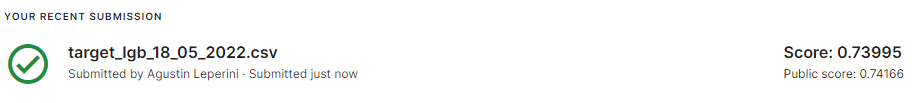

### Optional: Using Scikit Learn Pipelines 

So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.

In [ ]:
### Complete in this cell: use a sklearn Pipeline to automate the cleaning, standardizing and training 